In [1]:
import os
import numpy as np
import pickle as pkl
import pandas as pd
import nibabel as nib

from os.path import join as pjoin
from scipy.stats import pearsonr, sem, zscore, spearmanr
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from magicbox.io.io import CiftiReader, save2cifti, GiftiReader
from magicbox.vis.plot import plot_line, plot_polyfit
from magicbox.stats.outlier import outlier_iqr
from cxy_visual_dev.lib.predefine import proj_dir, Atlas,\
    get_rois, s1200_avg_eccentricity, s1200_avg_RFsize,\
    LR_count_32k, mmp_map_file, get_rois, mmp_name2label,\
    meas2color, s1200_midthickness_L, s1200_midthickness_R,\
    s1200_avg_R2
from cxy_visual_dev.lib.algo import AgeSlideWindow

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'data_for_paper_20230720')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 各种PC与视觉加工层级量化指标之间的相关

## RFsize

### limit RFsize

In [3]:
mask_type = 'Wang2015'
visual_angle_limit = 8  # None, 8
Hemi = 'L'
out_name =  f'PC-corr-RFsize_angle{visual_angle_limit}-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.csv')

# ===prepare mask===
mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
if mask_type == 'MMP-vis3':
    pass
elif mask_type == 'R2_limit':
    mask_tmp = nib.load(s1200_avg_R2).get_fdata()[0, :LR_count_32k] > 9.8
    mask = np.logical_and(mask, mask_tmp)
elif mask_type == 'Wang2015':
    mask_tmp = Atlas('Wang2015').get_mask(get_rois(f'Wang2015-{Hemi}'))[0]
    mask = np.logical_and(mask, mask_tmp)
else:
    raise ValueError('unsupported mask_type:', mask_type)

# ===prepare gradient maps===
# 结构梯度的PC1
map_stru_pc = nib.load(pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[0, mask][None, :]
grad_names = ['stru-PC1']
grad_maps = [map_stru_pc]

# Margulies gradient
map_margulies_c = nib.load(pjoin(
    proj_dir, 'data/neuromaps-data/annotations/margulies2016/'
    'source-margulies2016_space-fsLR_den-32k_feature.dscalar.nii'
)).get_fdata()[0, mask][None, :]
grad_names.append('Margulies-C1')
grad_maps.append(map_margulies_c)

# RSFC矩阵的PCA成分
reader = CiftiReader(pjoin(
    anal_dir, 'decomposition/'
    f'S1200-grp-RSFC-z_MMP-vis3-{Hemi}2MMP-vis3-{Hemi}_zscore_PCA-comp.dscalar.nii'))
map_rsfc_c = reader.get_data()[0, :LR_count_32k][mask][None, :]
grad_names.append(f'RSFC-P{reader.map_names()[0]}')
grad_maps.append(map_rsfc_c)

grad_maps = np.concatenate(grad_maps, 0)
n_grad = len(grad_names)

# ===prepare retinotopic map===
map_meas = nib.load(s1200_avg_RFsize).get_fdata()[0, :LR_count_32k]
map_meas = map_meas[mask]

if visual_angle_limit is not None:
    angle_mask = map_meas <= visual_angle_limit
    grad_maps = grad_maps[:, angle_mask]
    map_meas = map_meas[angle_mask]
print('n_vtx:', map_meas.shape[0])

rs = np.zeros(n_grad)
ps = np.zeros(n_grad)
for grad_idx in range(n_grad):
    r, p = pearsonr(map_meas, grad_maps[grad_idx])
    rs[grad_idx] = r
    ps[grad_idx] = p

out_dict = {'gradient': grad_names, 'r': rs, 'p': ps}
out_df = pd.DataFrame(out_dict)
out_df.to_csv(out_file, index=False)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


n_vtx: 2514


### limit Ecc

In [3]:
iqr_coef = 1.5
mask_type = 'Wang2015'
visual_angle_limit = 8  # None, 8
Hemi = 'R'
out_name =  f'PC-corr-RFsize_Ecc-lim-{visual_angle_limit}_{iqr_coef}IQR_{Hemi}H'
out_file = pjoin(work_dir, f'{out_name}.csv')

# ===prepare mask===
mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
if mask_type == 'MMP-vis3':
    pass
elif mask_type == 'R2_limit':
    mask_tmp = nib.load(s1200_avg_R2).get_fdata()[0, :LR_count_32k] > 9.8
    mask = np.logical_and(mask, mask_tmp)
elif mask_type == 'Wang2015':
    mask_tmp = Atlas('Wang2015').get_mask(get_rois(f'Wang2015-{Hemi}'))[0]
    mask = np.logical_and(mask, mask_tmp)
else:
    raise ValueError('unsupported mask_type:', mask_type)

# ===prepare gradient maps===
# 结构梯度的PC1
map_stru_pc = nib.load(pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[0, mask][None, :]
grad_names = ['stru-PC1']
grad_maps = [map_stru_pc]

# Margulies gradient
map_margulies_c = nib.load(pjoin(
    proj_dir, 'data/neuromaps-data/annotations/margulies2016/'
    'source-margulies2016_space-fsLR_den-32k_feature.dscalar.nii'
)).get_fdata()[0, mask][None, :]
grad_names.append('Margulies-C1')
grad_maps.append(map_margulies_c)

# RSFC矩阵的PCA成分
reader = CiftiReader(pjoin(
    anal_dir, 'decomposition/'
    f'S1200-grp-RSFC-z_MMP-vis3-{Hemi}2MMP-vis3-{Hemi}_zscore_PCA-comp.dscalar.nii'))
map_rsfc_c = reader.get_data()[0, :LR_count_32k][mask][None, :]
grad_names.append(f'RSFC-P{reader.map_names()[0]}')
grad_maps.append(map_rsfc_c)

grad_maps = np.concatenate(grad_maps, 0)
n_grad = len(grad_names)

# ===prepare retinotopic map===
map_meas = nib.load(s1200_avg_RFsize).get_fdata()[0, :LR_count_32k]
map_meas = map_meas[mask]

if visual_angle_limit is not None:
    ecc_map = nib.load(s1200_avg_eccentricity).get_fdata()[0, :LR_count_32k]
    angle_mask = ecc_map[mask] <= visual_angle_limit
    grad_maps = grad_maps[:, angle_mask]
    map_meas = map_meas[angle_mask]
print('n_vtx:', map_meas.shape[0])

rs = np.zeros(n_grad)
ps = np.zeros(n_grad)
for grad_idx in range(n_grad):
    if iqr_coef is not None:
        outlier_mask1 = outlier_iqr(map_meas, iqr_coef)
        outlier_mask2 = outlier_iqr(grad_maps[grad_idx], iqr_coef)
        outlier_mask = np.logical_or(outlier_mask1, outlier_mask2)
        non_outlier_mask = ~outlier_mask
        x = map_meas[non_outlier_mask]
        y = grad_maps[grad_idx][non_outlier_mask]
    else:
        x = map_meas
        y = grad_maps[grad_idx]
    r, p = pearsonr(x, y)
    rs[grad_idx] = r
    ps[grad_idx] = p

out_dict = {'gradient': grad_names, 'r': rs, 'p': ps}
out_df = pd.DataFrame(out_dict)
out_df.to_csv(out_file, index=False)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


n_vtx: 2441


## Hierarchical Rank

In [3]:
Hemi = 'L'
path_name = 'Hierarchy3'
figsize = (3, 3)
rois_plot = get_rois(path_name)
rois = [f'{Hemi}_{i}' for i in rois_plot]
out_name = f'PC-corr-{path_name}_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.csv')

# ===prepare PC maps===
# 结构梯度的PC1, PC2: stru-C1, stru-C2;
map_stru_pc = nib.load(pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[[0]]
pc_names = ['stru-PC1']
pc_maps = [map_stru_pc]

# Margulies gradient
map_margulies_c = nib.load(pjoin(
    proj_dir, 'data/neuromaps-data/annotations/margulies2016/'
    'source-margulies2016_space-fsLR_den-32k_feature.dscalar.nii'
)).get_fdata()[[0]]
pc_names.append('Margulies-C1')
pc_maps.append(map_margulies_c)

# RSFC矩阵的PCA成分
reader = CiftiReader(pjoin(
    anal_dir, 'decomposition/'
    f'S1200-grp-RSFC-z_MMP-vis3-{Hemi}2MMP-vis3-{Hemi}_zscore_PCA-comp.dscalar.nii'))
map_rsfc_pc = reader.get_data()[[0], :LR_count_32k]
pc_names.append(f'RSFC-P{reader.map_names()[0]}')
pc_maps.append(map_rsfc_pc)

pc_maps = np.concatenate(pc_maps, 0)
n_pc_map = len(pc_names)

# ===prepare data===
n_roi = len(rois)
x = np.arange(1, n_roi+1)
atlas = Atlas('HCP-MMP')
rs = np.zeros(n_pc_map)
ps = np.zeros(n_pc_map)
for pc_idx in range(n_pc_map):
    y =  np.zeros(n_roi)
    for roi_idx, roi in enumerate(rois):
        roi_mask = atlas.get_mask(roi)[0]
        y[roi_idx] = np.mean(pc_maps[pc_idx][roi_mask])
    r, p = spearmanr(x, y, alternative='two-sided')
    rs[pc_idx] = r
    ps[pc_idx] = p

out_dict = {'gradient': pc_names, 'r': rs, 'p': ps}
out_df = pd.DataFrame(out_dict)
out_df.to_csv(out_file, index=False)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# 初始化表格

## PC2几何锚点信息

In [2]:
Hemis = ('L', 'R')
seed_name2vtx_L = {
    'Early': [24939, 24324],
    'Dorsal': [12485, 12545],
    'Lateral': [23474, 15570],
    'Ventral': [21501, 22655]}
seed_name2vtx_R = {
    'Early': [24938, 24433],
    'Dorsal': [12442, 12586],
    'Lateral': [23526, 15523],
    'Ventral': [21501, 22485]}
out_file = pjoin(work_dir, 'EDLV-seed-v1.xlsx')

Hemi2seed_dict = {'L': seed_name2vtx_L, 'R': seed_name2vtx_R}
Hemi2geo_file = {'L': s1200_midthickness_L, 'R': s1200_midthickness_R}

out_dict = {'Hemisphere': [], 'Vertex ID': [], 'Description': [],
            'x': [], 'y': [], 'z': [], 'Location (refer to Destrieux Atlas)': []}
for Hemi in Hemis:
    reader = GiftiReader(Hemi2geo_file[Hemi])
    coords = reader.coords
    for seed_name, seed_vertices in Hemi2seed_dict[Hemi].items():
        if seed_name == 'Early':
            descrip_msg = f'in {seed_name} Visual Cortex'
        else:
            descrip_msg = f'in {seed_name} Visual Stream'
        for idx, seed_vtx in enumerate(seed_vertices, 1):
            out_dict['Hemisphere'].append(f'{Hemi}H')
            out_dict['Vertex ID'].append(seed_vtx)
            out_dict['Description'].append(f'local minimum{idx} {descrip_msg}')
            out_dict['x'].append(coords[seed_vtx, 0])
            out_dict['y'].append(coords[seed_vtx, 1])
            out_dict['z'].append(coords[seed_vtx, 2])
            out_dict['Location (refer to Destrieux Atlas)'].append(None)

out_df = pd.DataFrame(out_dict)
out_df.to_excel(out_file, index=False)

## 视觉脑区表

In [2]:
rois = get_rois('MMP-vis3-R')
roi_keys = [mmp_name2label[i] for i in rois]
roi_lbls = [i[2:] for i in rois]
out_dict = {'Parcel Index': roi_keys, 'Area Name': roi_lbls}
out_df = pd.DataFrame(out_dict)
out_df.to_excel(pjoin(work_dir, 'visual_area.xlsx'), index=False)


# prepare for ANOVA

## grad_predict_ROI9 or PC_predict_ALFF1

In [5]:
pc_names = ('C1', 'C2', 'C1+2')

# pkl_file = pjoin(anal_dir, 'predict/grad-predict-ROI9_stru-{pc_name}_rand-100_R.pkl')
# out_file = pjoin(work_dir, f'grad-predict-ROI9_stru_rand-100_R.csv')

pkl_file = pjoin(anal_dir, 'predict/P{pc_name}_predict_fALFF1_rand-100_RH.pkl')
out_file = pjoin(work_dir, 'PC_predict_fALFF1_rand-100_RH.csv')

out_data = {'Group': [], 'Acc': []}
for pc_num, pc_name in enumerate(pc_names, 1):
    data = pkl.load(open(
        pkl_file.format(pc_name=pc_name), 'rb'))
    acc_vec = np.mean(data['test_score'], 1)
    out_data['Acc'].extend(acc_vec)
    out_data['Group'].extend([pc_num] * len(acc_vec))
    print(f'{pc_name} to Group ID:', pc_num)
out_df = pd.DataFrame(out_data)
out_df.to_csv(out_file, index=False)


C1 to Group ID: 1
C2 to Group ID: 2
C1+2 to Group ID: 3


## PC_predict_ROI7

In [2]:
title = 'PC_predict_ROI7'
trg_name = 'MMP-vis3-L'
pc_names = ('PC1', 'PC2', 'PC1+2')
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_trg-{trg}.pkl')
out_file = pjoin(work_dir, f'{title}_{trg_name}.csv')

out_data = {'Group': [], 'Acc': []}
for pc_num, pc_name in enumerate(pc_names, 1):
    data = pkl.load(open(
        pkl_file.format(title=title, pc_name=pc_name, trg=trg_name), 'rb'
    ))
    out_data['Acc'].extend(data['test_score'])
    out_data['Group'].extend([pc_num] * len(data['test_score']))
    print(f'{pc_name} to Group ID:', pc_num)
out_df = pd.DataFrame(out_data)
out_df.to_csv(out_file, index=False)


PC1 to Group ID: 1
PC2 to Group ID: 2
PC1+2 to Group ID: 3


## PC_predict_ALFF

In [3]:
Hemi = 'RH'
pc_names = ('PC1', 'PC2', 'PC1+2')
trg_name = 'fALFF'
pkl_file = pjoin(anal_dir, 'predict/{pc}_predict_{trg}_{Hemi}.pkl')
out_file = pjoin(work_dir, f'PC_predict_{trg_name}_{Hemi}.csv')

out_data = {'Group': [], 'R2': []}
for pc_num, pc_name in enumerate(pc_names, 1):
    data = pkl.load(open(
        pkl_file.format(pc=pc_name, trg=trg_name, Hemi=Hemi), 'rb'
    ))
    out_data['R2'].extend(data['test_score'])
    out_data['Group'].extend([pc_num] * len(data['test_score']))
    print(f'{pc_name} to Group ID:', pc_num)
out_df = pd.DataFrame(out_data)
out_df.to_csv(out_file, index=False)


PC1 to Group ID: 1
PC2 to Group ID: 2
PC1+2 to Group ID: 3


# 左右脑对应PC之间的相关

In [2]:
pc_names = tuple(f'PC{i}' for i in range(1, 11))
pc_file_l = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_MMP-vis3-L_zscore1_PCA-subj.dscalar.nii')
pc_file_r = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')

pc_maps_l = CiftiReader(pc_file_l).get_data('CIFTI_STRUCTURE_CORTEX_LEFT', True)
pc_maps_r = CiftiReader(pc_file_r).get_data('CIFTI_STRUCTURE_CORTEX_RIGHT', True)
print(pc_maps_l.shape)
print(pc_maps_r.shape)

reader = CiftiReader(mmp_map_file)
mmp_map_l = reader.get_data('CIFTI_STRUCTURE_CORTEX_LEFT', True)[0]
mmp_map_r = reader.get_data('CIFTI_STRUCTURE_CORTEX_RIGHT', True)[0]
mask_l = np.zeros_like(mmp_map_l, bool)
mask_r = np.zeros_like(mmp_map_r, bool)
for roi in get_rois('MMP-vis3-L'):
    mask_l = np.logical_or(mask_l, mmp_map_l == mmp_name2label[roi])
for roi in get_rois('MMP-vis3-R'):
    mask_r = np.logical_or(mask_r, mmp_map_r == mmp_name2label[roi])
print('n_vtx of mask_l', np.sum(mask_l))
print('n_vtx of mask_r', np.sum(mask_r))
mask = np.logical_and(mask_l, mask_r)
print('n_vtx of mask:', np.sum(mask))

print('===PC_L-corr-R===')
print('PC name: r; p')
for pc_idx, pc_name in enumerate(pc_names):
    r, p = pearsonr(pc_maps_l[pc_idx, mask], pc_maps_r[pc_idx, mask])
    print(f'{pc_name}: {r}; {p}')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(20, 32492)
(20, 32492)
n_vtx of mask_l 6849
n_vtx of mask_r 6747
n_vtx of mask: 6584
===PC_L-corr-R===
PC name: r; p
PC1: 0.9881989454190239; 0.0
PC2: 0.9390732049353178; 0.0
PC3: -0.8653490724523865; 0.0
PC4: 0.8464355875545557; 0.0
PC5: -0.39776436457756487; 1.687839963861709e-248
PC6: -0.3799014081016432; 4.374759020526336e-225
PC7: 0.21625835689504314; 1.583280711116812e-70
PC8: 0.18806748444520618; 1.7735614117159673e-53
PC9: -0.23375029431382255; 2.0631331912909536e-82
PC10: 0.5573782151861703; 0.0


# 调整map的值

## 将PC map减去其自身的最小值

In [2]:
Hemis = ('L', 'R')
pc_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj_min-0.dscalar.nii')

for Hemi in Hemis:
    reader = CiftiReader(pc_file.format(Hemi=Hemi))
    data = reader.get_data()
    data = data - np.nanmin(data, 1, keepdims=True)
    save2cifti(out_file.format(Hemi=Hemi), data, reader.brain_models(), reader.map_names())


## 将几何模型进行zscore

In [2]:
atlas = Atlas('HCP-MMP')
mask = atlas.get_mask(get_rois('MMP-vis3-L') + get_rois('MMP-vis3-R'))[0]
geo_file1 = pjoin(
        anal_dir, 'gdist/gdist_src-CalcarineSulcus.dscalar.nii')
geo_file2 = pjoin(
        anal_dir, 'gdist/gdist4_src-EDLV-seed-v1.dscalar.nii')
geo_files = [geo_file1, geo_file2]

for geo_file in geo_files:
    fname = os.path.basename(geo_file).split('.')[0]
    out_file = pjoin(work_dir, f'{fname}_MMP-vis3_zscore.dscalar.nii')
    reader = CiftiReader(geo_file)
    data = reader.get_data()
    data[:, ~mask] = np.nan
    data[:, mask] = zscore(data[:, mask], 1)
    save2cifti(out_file, data, reader.brain_models(),
               reader.map_names(), reader.volume, reader.label_tables())


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [5]:
# 逆运算
v_in_data2 = 1.8
atlas = Atlas('HCP-MMP')
mask = atlas.get_mask(get_rois('MMP-vis3-L') + get_rois('MMP-vis3-R'))[0]
geo_file1 = pjoin(
        anal_dir, 'gdist/gdist_src-CalcarineSulcus.dscalar.nii')
geo_file2 = pjoin(
        anal_dir, 'gdist/gdist4_src-EDLV-seed-v1.dscalar.nii')
geo_files = [geo_file1, geo_file2]

for geo_file in geo_files:
    geo_map = nib.load(geo_file).get_fdata()[0]
    assert nib.load(geo_file).shape[0] == 1
    fname = os.path.basename(geo_file).split('.')[0]
    fpath = pjoin(work_dir, f'{fname}_MMP-vis3_zscore.dscalar.nii')
    geo_map_zscore = nib.load(fpath).get_fdata()[0]
    assert nib.load(fpath).shape[0] == 1

    data1 = geo_map[mask]
    data2 = geo_map_zscore[mask]
    data1_mean = np.mean(data1)
    data1_std = np.std(data1)
    np.testing.assert_almost_equal(data1, data2 * data1_std + data1_mean, 14)
    v_in_data1 = v_in_data2 * data1_std + data1_mean

    print(f'==={fname}===')
    print(f'{v_in_data2} is related to {v_in_data1}')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


===gdist_src-CalcarineSulcus===
1.8 is related to 81.2010106427525
===gdist4_src-EDLV-seed-v1===
1.8 is related to 35.32103069570686


## 将fALFF map进行zscore

In [2]:
atlas = Atlas('HCP-MMP')
mask = atlas.get_mask(get_rois('MMP-vis3-L') + get_rois('MMP-vis3-R'), 'grayordinate')[0]
src_file = pjoin(anal_dir, 'AFF/HCPY-faff.dscalar.nii')
out_file = pjoin(work_dir, 'HCPY-faff_MMP-vis3_zscore.dscalar.nii')

reader = CiftiReader(src_file)
data = reader.get_data()
data[:, ~mask] = np.nan
data[:, mask] = zscore(data[:, mask], 1)
save2cifti(out_file, data, reader.brain_models(),
           reader.map_names(), reader.volume, reader.label_tables())


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
# 逆运算
v_in_data2 = 1.5
atlas = Atlas('HCP-MMP')
mask = atlas.get_mask(get_rois('MMP-vis3-L') + get_rois('MMP-vis3-R'), 'grayordinate')[0]
fpath1 = pjoin(anal_dir, 'AFF/HCPY-faff.dscalar.nii')
fpath2 = pjoin(work_dir, 'HCPY-faff_MMP-vis3_zscore.dscalar.nii')

reader1 = CiftiReader(fpath1)
reader2 = CiftiReader(fpath2)
assert reader1.map_names() == reader2.map_names()
assert reader1.map_names() == ['LFF', 'slow5', 'slow4', 'slow3', 'slow2', 'slow1']
data1 = reader1.get_data()[0, mask]
data2 = reader2.get_data()[0, mask]
data1_mean = np.mean(data1)
data1_std = np.std(data1)
np.testing.assert_almost_equal(data1, data2 * data1_std + data1_mean, 15)
v_in_data1 = v_in_data2 * data1_std + data1_mean
print(f'{v_in_data2} is related to {v_in_data1}')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


1.5 is related to 0.18637160486600307


# HCPYA整体PCA的方差解释率

In [7]:
mod_name = 'M+corrT'  # M, corrT, half0-M+corrT, M+corrT
Hemis = ('L', 'R')
pca_file = pjoin(anal_dir, 'decomposition/'
                 'HCPY-{mod}_MMP-vis3-{Hemi}_zscore1_PCA-subj.pkl')
out_file = pjoin(work_dir, f'HCPY-PC-Var_{mod_name}.csv')

data = {}
for Hemi in Hemis:
    pca = pkl.load(open(pca_file.format(mod=mod_name, Hemi=Hemi), 'rb'))
    data[f'{Hemi}H'] = pca.explained_variance_ratio_
n_pc = len(data['LH'])
assert n_pc == len(data['RH'])
data['PC_name'] = [f'PC{i}' for i in range(1, n_pc+1)]

df = pd.DataFrame(data)
df.to_csv(out_file, index=False)

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 髓鞘含量和皮质厚度分别在主次梯度中的贡献比例

In [2]:
Hemis = ('L', 'R')
pc_names = ('C1', 'C2')
meas_names = ('Myelination', 'Thickness')
meas2file = {
    'Myelination': pjoin(anal_dir, 'decomposition/'
        'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj_M.csv'),
    'Thickness': pjoin(anal_dir, 'decomposition/'
        'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj_corrT.csv')}
out_file = pjoin(work_dir, 'HCPY-M+T_contribute_PC1+2.csv')

n_meas = len(meas_names)
n_pc = len(pc_names)
data = {'measurement': meas_names}
for Hemi in Hemis:
    y = np.zeros((n_meas, n_pc))
    for meas_idx, meas_name in enumerate(meas_names):
        fpath = meas2file[meas_name].format(Hemi=Hemi)
        df = pd.read_csv(fpath)
        for pc_idx, pc_name in enumerate(pc_names):
            samples = np.abs(df[pc_name].values)
            y[meas_idx, pc_idx] = np.sum(samples)
    y /= np.sum(y, 0, keepdims=True)

    for pc_idx, pc_name in enumerate(pc_names):
        data[f'{Hemi}H_P{pc_name}'] = y[:, pc_idx]

df = pd.DataFrame(data)
df.to_csv(out_file, index=False)

# 其它方式PCA得到的成分与PC1，PC2的相关

In [4]:
mod_name = 'half0-M+corrT'  # M, corrT, half0-M+corrT
Hemis = ['L', 'R']
vis_names = 'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
pc_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
c_names = ('C1', 'C2')
mod_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-{mod}_{vis_name}_zscore1_PCA-subj.dscalar.nii')
out_name = f'{mod_name}-C1+2-corr-PC1+2'
out_file = pjoin(work_dir, f'{out_name}.csv')

n_pc = len(pc_names)
n_c = len(c_names)
out_dict = {}
for Hemi in Hemis:
    vis_name = vis_names.format(Hemi=Hemi)
    vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
    pc_maps = nib.load(
        pc_file.format(vis_name=vis_name)).get_fdata()[:n_pc, vis_mask]
    c_maps = nib.load(
        mod_file.format(mod=mod_name, vis_name=vis_name)
    ).get_fdata()[:n_c, vis_mask]
    for c_idx, c_name in enumerate(c_names):
        out_dict[f'{Hemi}H_{c_name} (r)'] = np.zeros(n_pc)
        out_dict[f'{Hemi}H_{c_name} (p)'] = np.zeros(n_pc)
        for pc_idx, pc_name in enumerate(pc_names):
            r, p = pearsonr(pc_maps[pc_idx], c_maps[c_idx])
            out_dict[f'{Hemi}H_{c_name} (r)'][pc_idx] = r
            out_dict[f'{Hemi}H_{c_name} (p)'][pc_idx] = p

out_df = pd.DataFrame(out_dict, index=pc_names)
out_df.to_csv(out_file, index=True)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# 主次梯度分别在整个视觉皮层以及EDLV四个部分内的值

In [2]:
Hemis = ('L', 'R')
pc_names = ('PC1', 'PC2')
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
atlas = Atlas('HCP-MMP')
pc_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
edlv_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')
out_file = pjoin(work_dir, 'PC1+2_in_EDLV.pkl')

reader = CiftiReader(edlv_file)
edlv_data = reader.get_data()[0]
lbl_tab = reader.label_tables()[0]
data = {}
for pc_name in pc_names:
    data[pc_name] = {}
for Hemi in Hemis:
    vis_name = f'MMP-vis3-{Hemi}'
    vis_mask = atlas.get_mask(get_rois(vis_name))[0]
    pc_maps = nib.load(
        pc_file.format(vis_name=vis_name)
    ).get_fdata()[:2, vis_mask]

    edlv_map = edlv_data[vis_mask]
    edlv_keys = np.unique(edlv_map)
    edlv_name2mask = {}
    for edlv_k in edlv_keys:
        edlv_n = lbl_tab[edlv_k].label.lstrip(f'{Hemi}_')
        if edlv_n == 'boundary':
            continue
        edlv_name2mask[edlv_n] = edlv_map == edlv_k

    for pc_idx, pc_name in enumerate(pc_names):
        data[pc_name][f'{Hemi}H_whole'] = pc_maps[pc_idx]
        for edlv_n in edlv_names:
            mask = edlv_name2mask[edlv_n]
            data[pc_name][f'{Hemi}H_{edlv_n}'] = pc_maps[pc_idx][mask]
pkl.dump(data, open(out_file, 'wb'))


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# 将所有顶点对以测地距离由小到大排列，然后均匀分成几份

## 在各部分均分的空间范围内，首先逐顶点总结其与范围内的顶点的梯度距离的mean统计值，然后跨顶点计算该统计值的mean和sem

In [3]:
n_seg = 100
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
out_file = pjoin(work_dir, f'grad-dist_vs_geo-dist_row-mean_seg{n_seg}_{vis_name}.pkl')

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))

n_pc = len(pc_names)
# prepare geodesic and gradient distance
geo_dist_arr = geo_dist['gdist']
grad_dist_arrs = [grad_dist[f'{i}-zscore'] for i in pc_names]

# prepare segments
n_vtx = geo_dist_arr.shape[0]
idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
geo_dist_vec = geo_dist_arr[idx_mat]
n_pair = len(geo_dist_vec)
sort_indices = np.argsort(geo_dist_vec)
seg_indices = np.linspace(0, n_pair, n_seg+1, endpoint=True, dtype=int)

# mask gradient distance
out_data = {'segment': [], 'segment_dist': np.zeros(n_seg)}
for pc_name in pc_names:
    out_data[f'{pc_name}_mean'] = np.zeros(n_seg)
    out_data[f'{pc_name}_sem'] = np.zeros(n_seg)
for idx, seg_idx_s in enumerate(seg_indices[:-1]):
    seg_idx_e = seg_indices[idx + 1]
    indices = sort_indices[seg_idx_s:seg_idx_e]
    geo_mask_vec = np.zeros(n_pair, dtype=bool)
    geo_mask_vec[indices] = True
    geo_mask_arr = np.zeros((n_vtx, n_vtx), dtype=bool)
    geo_mask_arr[idx_mat] = geo_mask_vec
    geo_mask_arr = np.logical_or(geo_mask_arr, geo_mask_arr.T)
    for pc_idx, pc_name in enumerate(pc_names):
        pc_dist_arr = grad_dist_arrs[pc_idx]
        pc_dist_vec = []
        for vtx_idx in range(n_vtx):
            row_data = pc_dist_arr[vtx_idx][geo_mask_arr[vtx_idx]]
            n_valid = len(row_data)
            if n_valid > 0:
                pc_dist_vec.append(np.mean(row_data))
        out_data[f'{pc_name}_mean'][idx] = np.mean(pc_dist_vec)
        out_data[f'{pc_name}_sem'][idx] = sem(pc_dist_vec)
    out_data['segment'].append('{:.2f}~{:.2f}'.format(
        geo_dist_vec[indices[0]], geo_dist_vec[indices[-1]]))
    out_data['segment_dist'][idx] = np.mean(geo_dist_vec[indices])

# save
pkl.dump(out_data, open(out_file, 'wb'))


# 主次梯度以及视网膜拓扑参数在Wang2015范围内的值

## 提取数据

In [2]:
vis_angle_limit = 8  # None, 8
Hemis = ('L', 'R')
n_pc = 2
pc_names = [f'PC{i}' for i in range(1, n_pc + 1)]
pc_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii')
meas_names = ('RFsize', 'Eccentricity')
meas2file = {
    'Eccentricity': s1200_avg_eccentricity,
    'RFsize': s1200_avg_RFsize}
out_file = pjoin(work_dir, f'PC1+2-corr-retinotopy_Wang2015_Ecc-lim-{vis_angle_limit}.pkl')

atlas1 = Atlas('HCP-MMP')
atlas2 = Atlas('Wang2015')
data = {}
for Hemi in Hemis:
    mask1 = atlas1.get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
    mask2 = atlas2.get_mask(get_rois(f'Wang2015-{Hemi}'))[0]
    mask = np.logical_and(mask1, mask2)

    if vis_angle_limit is not None:
        ecc_map = nib.load(s1200_avg_eccentricity).get_fdata()[0, :LR_count_32k]
        angle_mask = ecc_map <= vis_angle_limit
        mask = np.logical_and(mask, angle_mask)
    print('n_vtx:', np.sum(mask))

    map_pcs = nib.load(
        pc_file.format(Hemi=Hemi)).get_fdata()[:n_pc, mask]
    for pc_idx, pc_name in enumerate(pc_names):
        data[f'{Hemi}H_{pc_name}'] = map_pcs[pc_idx]

    for meas_name in meas_names:
        map_meas = nib.load(meas2file[meas_name]).get_fdata()[0, :LR_count_32k]
        data[f'{Hemi}H_{meas_name}'] = map_meas[mask]

pkl.dump(data, open(out_file, 'wb'))


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


n_vtx: 2509
n_vtx: 2441


## Plot


---PC1---
n_vtx 2440
polynomial:
  
5.935 x - 28.6

score: PearsonRResult(statistic=0.661747242163385, pvalue=2.5197284913560702e-307)
pearsonr(x, y, alternative='two-sided'):
 PearsonRResult(statistic=0.6617472421633851, pvalue=2.5197284913560702e-307)

---PC2---
n_vtx 2426
polynomial:
  
0.1753 x - 2.895

score: PearsonRResult(statistic=0.03257208884386837, pvalue=0.1087319566728472)
pearsonr(x, y, alternative='two-sided'):
 PearsonRResult(statistic=0.03257208884386832, pvalue=0.1087319566728597)


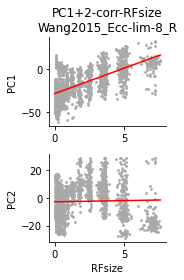

In [3]:
iqr_coef = 1.5  # 1.5, 2, 3, None
figsize = (2.5, 4)
Hemi = 'R'
meas_name = 'RFsize'  # RFsize, Eccentricity
pc_names = ['PC1', 'PC2']
src_file = pjoin(work_dir, 'PC1+2-corr-retinotopy_Wang2015_Ecc-lim-8.pkl')
out_name1 =  f'PC1+2-corr-{meas_name}'
out_name2 =  f'Wang2015_Ecc-lim-8_{Hemi}'
out_file = pjoin(work_dir, f'{out_name1}_{out_name2}.jpg')
out_file = 'show'

plot_data_file = pjoin(work_dir, f'{out_name1}_{out_name2}H_{iqr_coef}IQR.pkl')
# plot_data_file = None

n_pc = len(pc_names)
data = pkl.load(open(src_file, 'rb'))
fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
x_raw = data[f'{Hemi}H_{meas_name}']
if iqr_coef is not None:
    outlier_mask1 = outlier_iqr(x_raw, iqr_coef)
plot_data = {}
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    print(f'\n---{pc_name}---')
    y = data[f'{Hemi}H_{pc_name}']
    if iqr_coef is not None:
        outlier_mask2 = outlier_iqr(y, iqr_coef)
        outlier_mask = np.logical_or(outlier_mask1, outlier_mask2)
        non_outlier_mask = ~outlier_mask
        x = x_raw[non_outlier_mask]
        y = y[non_outlier_mask]
    else:
        x = x_raw
    print('n_vtx', len(x))
    plot_polyfit(x, y, 1, color='r', c='darkgray', s=3, ax=ax)
    print("pearsonr(x, y, alternative='two-sided'):\n",
          pearsonr(x, y, alternative='two-sided'))
    ax.set_ylabel(pc_name)
    if pc_idx == (n_pc - 1):
        ax.set_xlabel(meas_name)
    elif pc_idx == 0:
        ax.set_title(f'{out_name1}\n{out_name2}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plot_data[pc_name] = {}
    plot_data[pc_name]['PC score'] = y
    plot_data[pc_name][meas_name] = x

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

if plot_data_file is not None:
    pkl.dump(plot_data, open(plot_data_file, 'wb'))


# 十个腹侧视觉通路脑区的主次梯度值，以及脑区之间的层级关系

In [2]:
Hemis = ('L', 'R')
pc_names = ['PC1', 'PC2']
rois = get_rois('Hierarchy3')
fpath = pjoin(anal_dir, 'ROI_scalar/ROI_scalar1_MMP-vis3-{Hemi}.csv')
out_file = pjoin(work_dir, 'PC1+2-corr-Hierarchy.csv')

n_roi = len(rois)
data = {'ROI': rois, 'rank': np.arange(1, n_roi+1)}
for Hemi in Hemis:
    df = pd.read_csv(fpath.format(Hemi=Hemi), index_col=0)
    cols = [f'{Hemi}_{i}' for i in rois]
    for pc_name in pc_names:
        data[f'{Hemi}H_{pc_name}'] = \
            df.loc[f'mean_{pc_name}', cols].values

df = pd.DataFrame(data)
df.to_csv(out_file, index=False)


# 主次梯度与六层胞体密度之间的相关

In [2]:
Hemis = ('L', 'R')
pc_names = ('C1', 'C2')
fpath = pjoin(anal_dir, 'bigbrain/to_32fsLR/PC12-corr-msp_{Hemi}.pkl')
out_file = pjoin(work_dir, 'PC1+2-corr-msp.csv')

out_dict = {'lyr_idx': None}
for Hemi in Hemis:
    data = pkl.load(open(fpath.format(Hemi=Hemi), 'rb'))
    if out_dict['lyr_idx'] is None:
        out_dict['lyr_idx'] = data['layer_name']
    else:
        assert out_dict['lyr_idx'] == data['layer_name']
    for pc_name in pc_names:
        out_dict[f'{Hemi}H_P{pc_name} (r)'] = data[f'{pc_name}_corr_layer-mean']
        out_dict[f'{Hemi}H_P{pc_name} (p)'] = data[f'{pc_name}_corr_layer-mean-p']

out_df = pd.DataFrame(out_dict)
out_df.to_csv(out_file, index=False)

# 主次梯度与视觉能力的典型相关

In [2]:
pc_name2v = {'PC1': 'v31', 'PC2': 'v32'}
Hemis = ('L', 'R')
pc_names = ('PC1', 'PC2')
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_MMP-vis3-{Hemi}_{v}.pkl')
out_file = pjoin(work_dir, 'weight-CCA-beh_first-pair.csv')

ps = []
out_dict = {'stats': ['r', 'p', 'p (FDR)', 'p (bonferroni)']}
for Hemi in Hemis:
    for pc_name in pc_names:
        cca_dict = pkl.load(open(fpath.format(
            Hemi=Hemi, v=pc_name2v[pc_name]), 'rb'))
        x = cca_dict['X_trans'][:, 0]
        y = cca_dict['Y_trans'][:, 0]
        r, p = pearsonr(x, y, alternative='greater')
        out_dict[f'{Hemi}H_{pc_name}'] = [r, p]
        ps.append(p)

_, ps_fdr, _, _ = multipletests(ps, 0.05, 'fdr_bh')
_, ps_bonf, _, _ = multipletests(ps, 0.05, 'bonferroni')
idx = 0
for Hemi in Hemis:
    for pc_name in pc_names:
        out_dict[f'{Hemi}H_{pc_name}'].extend([ps_fdr[idx], ps_bonf[idx]])
        idx += 1

out_df = pd.DataFrame(out_dict)
out_df.to_csv(out_file, index=False)

# 主次梯度的行为模式

In [2]:
Hemis = ('L', 'R')
pc_names = ('PC1', 'PC2')
pc_name2v = {'PC1': 'v31', 'PC2': 'v32'}
beh_cols = [
    'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj',
    'PMAT24_A_CR', 'ReadEng_Unadj', 'PicVocab_Unadj',
    'ProcSpeed_Unadj', 'VSPLOT_TC', 'SCPT_SEN', 'SCPT_SPEC',
    'IWRD_TOT', 'ListSort_Unadj', 'Odor_Unadj', 'EVA_Denom',
    'Mars_Final']
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_{vis_name}_{v}.pkl')
out_file = pjoin(work_dir, 'weight-CCA-beh_first-pair-weights.csv')

beh_name2ability = {
'PicSeq_Unadj':	'Nonverbal Episodic Memory',
'CardSort_Unadj': 'Cognitive Flexibility',
'Flanker_Unadj': 'Inhibitory Control and Attention',
'PMAT24_A_CR': 'Fluid Intelligence',
'ReadEng_Unadj': 'Reading Decoding',
'PicVocab_Unadj': 'Vocabulary Comprehension',
'ProcSpeed_Unadj': 'Processing Speed',
'VSPLOT_TC': 'Spatial Orientation Processing',
'SCPT_SEN': 'Sustained Attention Sensitivity',
'SCPT_SPEC': 'Sustained Attention Specificity',
'IWRD_TOT': 'Verbal Episodic Memory',
'ListSort_Unadj': 'Working Memory',
'Odor_Unadj': 'Odor Identification',
'EVA_Denom': 'Visual Acuity',
'Mars_Final': 'Contrast Sensitivity'}

out_dict = {'behavior_name': beh_cols,
            'assessment': [beh_name2ability[i] for i in beh_cols]}
for Hemi in Hemis:
    vis_name = f'MMP-vis3-{Hemi}'
    for pc_name in pc_names:
        cca_dict = pkl.load(open(fpath.format(
            vis_name=vis_name, v=pc_name2v[pc_name]), 'rb'))
        assert beh_cols == cca_dict['target names']
        beh_weights = cca_dict['model'].y_rotations_[:, 0]
        out_dict[f'{Hemi}H_{pc_name} (raw)'] = beh_weights

        ws = np.abs(beh_weights)
        bwrs = ws / np.sum(ws)
        out_dict[f'{Hemi}H_{pc_name} (BWR)'] = bwrs

        w2s = beh_weights ** 2
        bw2rs = w2s / np.sum(w2s)
        out_dict[f'{Hemi}H_{pc_name} (BW2R)'] = bw2rs

out_df = pd.DataFrame(out_dict)
out_df.to_csv(out_file, index=False)


LH beh-pattern_PC1-corr-PC2:
 PearsonRResult(statistic=0.0023847596477842258, pvalue=0.9932701065855439)

RH beh-pattern_PC1-corr-PC2:
 PearsonRResult(statistic=-0.3529509745465853, pvalue=0.19691285222801344)
===LH-PC1===
>>>BW2R
EVA_Denom(0.2683891468754891), VSPLOT_TC(0.2316708972220311), ReadEng_Unadj(0.0859001052904093), SCPT_SPEC(0.0823053008608857), ListSort_Unadj(0.0781895171033619), PicVocab_Unadj(0.0763354659227827), CardSort_Unadj(0.069423322325806), PicSeq_Unadj(0.0507502890614861), SCPT_SEN(0.0229918087074056), Mars_Final(0.0154988830407001), Flanker_Unadj(0.0069820385711041), Odor_Unadj(0.0050444182875395), PMAT24_A_CR(0.0049130641893779), IWRD_TOT(0.0009004302632585), ProcSpeed_Unadj(0.0007053122783618), BW2R<<<
cumulative BW2R from EVA_Denom to EVA_Denom 0.2683891468754891
cumulative BW2R from EVA_Denom to VSPLOT_TC 0.5000600440975203
cumulative BW2R from EVA_Denom to ReadEng_Unadj 0.5859601493879295
cumulative BW2R from EVA_Denom to SCPT_SPEC 0.6682654502488152
cumula

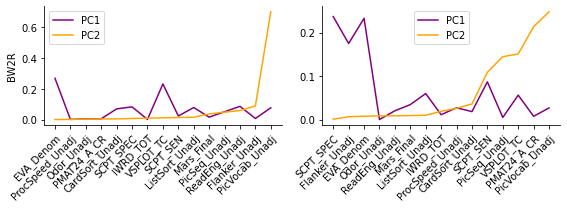

In [2]:
figsize = (8, 3)
metric = 'BW2R'
Hemis = ('L', 'R')
pc_names = ('PC1', 'PC2')
fpath = pjoin(work_dir, 'weight-CCA-beh_first-pair-weights.csv')
out_file = pjoin(work_dir, f'beh-pattern_{metric}.jpg')
# out_file = 'show'

n_hemi = len(Hemis)
n_pc = len(pc_names)
df = pd.read_csv(fpath)
beh_names = df['behavior_name'].values
n_beh = len(beh_names)
colors = tuple(meas2color[i] for i in pc_names)

ys = []
xticklabels = []
for Hemi in Hemis:
    y = np.zeros((n_pc, n_beh))
    for pc_idx, pc_name in enumerate(pc_names):
        y[pc_idx] = df[f'{Hemi}H_{pc_name} ({metric})'].values
        if pc_name == 'PC2':
            sorted_indices = np.argsort(y[pc_idx])
    y = y[:, sorted_indices]
    print(f'\n{Hemi}H beh-pattern_PC1-corr-PC2:\n', pearsonr(y[0], y[1]))
    ys.append(y)
    xticklabels.append(beh_names[sorted_indices])
    
plot_line(ys, 1, n_hemi, figsize, label=[pc_names] * 2,
          color=[colors] * 2, xticklabel=xticklabels,
          rotate_xticklabel=True, ylabel=metric, mode=out_file)

for Hemi_idx, Hemi in enumerate(Hemis):
    keys = xticklabels[Hemi_idx]
    values = ys[Hemi_idx]
    for pc_idx, pc_name in enumerate(pc_names):
        print(f'==={Hemi}H-{pc_name}===')
        sort_indices = np.argsort(values[pc_idx])[::-1]
        v_vec = values[pc_idx][sort_indices]
        k_vec = keys[sort_indices]
        print(f'>>>{metric}')
        for k, v in zip(k_vec, v_vec):
            print(f'{k}({v})', end=', ')
        print(f'{metric}<<<')
        cumulative_bwr = 0
        for trg_idx, trg_name in enumerate(k_vec):
            cumulative_bwr += v_vec[trg_idx]
            print(f'cumulative {metric} from {k_vec[0]} to {trg_name}', cumulative_bwr)
        print()


# 主梯度和次梯度与所有年纪窗口中前十个PCA成分(LC1~LC10)的皮尔逊相关

In [ ]:
Hemis = ('L', 'R')
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
dataset_names = ('HCPD', 'HCPY', 'HCPA')
dataset_name2file = {
    'HCPD': pjoin(anal_dir, 'RSM/RSM7_M+corrT_{vis_name}_zscore1_PCA-subj'
                  '_HCPY_corr_HCPD-SW-width50-step10-merge.pkl'),
    'HCPY': pjoin(anal_dir, 'RSM/RSM7_M+corrT_{vis_name}_zscore1_PCA-subj'
                  '_HCPY_corr_HCPY-SW-width50-step10.pkl'),
    'HCPA': pjoin(anal_dir, 'RSM/RSM7_M+corrT_{vis_name}_zscore1_PCA-subj'
                  '_HCPY_corr_HCPA-SW-width50-step10-merge.pkl')
}
sw_pc_names = 'all'
out_file = pjoin(work_dir, f'HCPY-PC12_corr_SW-PCs_{vis_name}.svg')
# out_file = 'show'

n_pc = len(pc_names)
n_ds = len(dataset_names)
pc2min = {}
for pc_name in pc_names:
    pc2min[pc_name] = {}
fig, axes = plt.subplots(n_pc, n_ds, figsize=figsize)
for dataset_idx, dataset_name in enumerate(dataset_names):
    fpath = dataset_name2file[dataset_name]
    data = pkl.load(open(fpath, 'rb'))
    if sw_pc_names == 'all':
        rows = data['row_name'][::-1]
    else:
        rows = sw_pc_names
    n_win = data['n_win']
    x = np.arange(n_win)
    xticks = [x[0], x[-1]]
    xticklabels = [1, n_win]
    for pc_idx, pc_name in enumerate(pc_names):
        ax = axes[pc_idx, dataset_idx]
        cols = [f'{pc_name}_corr_Win{i}' for i in range(1, n_win + 1)]
        col_indices = [data['col_name'].index(i) for i in cols]
        for row_name in rows:
            row_idx = data['row_name'].index(row_name)
            y = data['r'][row_idx, col_indices]
            if row_name in ('C1', 'C2'):
                color = meas2color[f'P{row_name}']
                if dataset_idx == 0 and pc_idx == n_pc-1:
                    ax.plot(x, y, c=color, label=row_name)
                else:
                    ax.plot(x, y, c=color)
                if row_name == pc_name[1:]:
                    pc2min[pc_name][dataset_name] = np.min(y)
            else:
                ax.plot(x, y, c='lightgray')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_yticks([0, 1])
        if pc_idx == 0:
            ax.set_title(dataset_name)
        if dataset_idx == 0:
            ax.set_ylabel('r')
        if pc_idx == n_pc-1:
            ax.set_xlabel('window')
            if dataset_idx == 0:
                ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
print(f'PC to minimum corr ({vis_name}):\n', pc2min)

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 所有窗口内的被试年龄

In [2]:
dataset_names = ('HCPD', 'HCPY', 'HCPA')
out_file = pjoin(work_dir, 'ages-in-window.pkl')

out_data = {}
for dataset_name in dataset_names:
    asw = AgeSlideWindow(dataset_name, 50, 10, True)
    out_data[dataset_name] = {}
    win_ids = np.arange(1, asw.n_win + 1)
    for win_id in win_ids:
        ages = asw.get_ages(win_id, 'year')
        out_data[dataset_name][f'Win{win_id}'] = ages

pkl.dump(out_data, open(out_file, 'wb'))
